# Import relevant modules

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

Imported modules.


# Load the dataset

In [4]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
# Shuffle the examples
train_df = train_df.reindex(np.random.permutation(train_df.index))
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

## Normalize values: Z-scores

In [5]:
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

print("Normalized the values.")

Normalized the values.


## Represent data
Create a feature layer containing three features:
- latitude X longitude
- meadian_income
- population

In [7]:
feature_columns = []

resolution_in_Zs = 0.3 # 3/10 of a standard deviation

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df_norm['latitude'])),
                                     int(max(train_df_norm['latitude'])),
                                     resolution_in_Zs))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df_norm['longitude'])),
                                     int(max(train_df_norm['longitude'])),
                                     resolution_in_Zs))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, longitude_boundaries)

# Create a feature cross of latitude and longitude.
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)

# Represent median_income as floating-point value.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Represent population as floating-point value.
population = tf.feature_column.numeric_column("population")
feature_columns.append(population)

# Convert the list of feature columns into layer that will later be fed into the model
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

# Define the plottiong function

In [9]:
def plot_the_loss_curve(epochs, mse):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")

    plt.plot(epochs, mse, label="Loss")
    plt.legend()
    plt.ylim([mse.min()*0.95, mse.max()*1.03])
    plt.show()

print("Defined the plot_loss_curve_function.")

Defined the plot_loss_curve_function.


# Build a linear regression model as a baseline

In [11]:
def create_model(my_learning_rate, feature_layer):
    """Create and compile a simple linear regression model."""

    model = tf.keras.models.Sequential()
    model.add(feature_layer)
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))
    model.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=my_learning_rate),
                  loss="mean_squared_error",
                  metrics=[tf.keras.metrics.MeanSquaredError()])
    
    return model

def train_model(model, dataset, epochs, batch_size, label_name):
    """Feed a dataset into the model in order to train it."""

    # Split the dataset into features and label.
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                        epochs=epochs, shuffle=True)
    
    # Get details that will be useful for plotting the loss curve.
    epochs= history.epoch
    hist = pd.DataFrame(history.history)
    rmse = hist["mean_squared_error"]

    return epochs, rmse

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


## Run baseline model

Epoch 1/15
17/17 [==============================] - 1s 1ms/step - loss: 0.9778 - mean_squared_error: 0.9778
Epoch 2/15
17/17 [==============================] - 0s 2ms/step - loss: 0.6639 - mean_squared_error: 0.6639
Epoch 3/15
17/17 [==============================] - 0s 1ms/step - loss: 0.5013 - mean_squared_error: 0.5013
Epoch 4/15
17/17 [==============================] - 0s 2ms/step - loss: 0.4133 - mean_squared_error: 0.4133
Epoch 5/15
17/17 [==============================] - 0s 1ms/step - loss: 0.3747 - mean_squared_error: 0.3747
Epoch 6/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3626 - mean_squared_error: 0.3626
Epoch 7/15
17/17 [==============================] - 0s 1ms/step - loss: 0.3607 - mean_squared_error: 0.3607
Epoch 8/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3601 - mean_squared_error: 0.3601
Epoch 9/15
17/17 [==============================] - 0s 1ms/step - loss: 0.3600 - mean_squared_error: 0.3600
Epoch 10/15
17/17 [=========

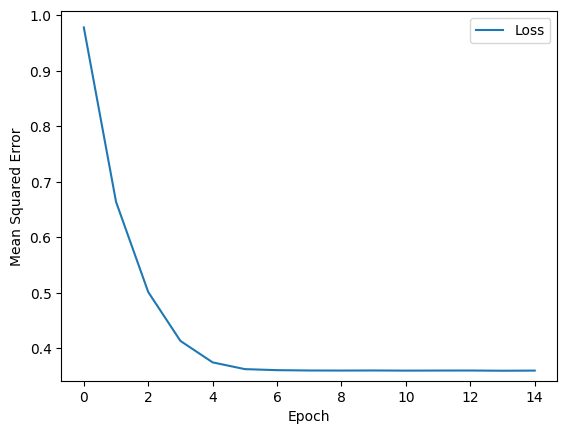


 Evaluate the linear regression model against the test set:
3/3 [==============================] - 0s 2ms/step - loss: 0.3957 - mean_squared_error: 0.3957


[0.3957277834415436, 0.3957277834415436]

In [12]:
# Hyperparameters.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

# Create the model.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on normalized training set.
epochs, mse = train_model(my_model, train_df_norm, epochs, batch_size, label_name)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in test_df_norm.items()}
# Isolate the label
test_label = np.array(test_features.pop(label_name))
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

# Define a deep neural net model and training function

In [40]:
def create_model(my_learning_rate, my_feature_layer):
    """Create and compile a deep learning neural network."""

    model = tf.keras.models.Sequential()
    model.add(my_feature_layer)

    # Define the firs hidden layer with 20 nodes.
    model.add(tf.keras.layers.Dense(units=20,
                                    activation='relu',
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.04), # L2 regularization
                                    name='Hidden1'))
    
    # # Implementing Dropout regularization
    # model.add(tf.keras.layers.Dropout(rate=0.25))

    # Define the firs hidden layer with 12 nodes.
    model.add(tf.keras.layers.Dense(units=12,
                                    activation='relu',
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.04), # L2 regularization
                                    name='Hidden2'))
    # Define the output layer.
    model.add(tf.keras.layers.Dense(units=1,
                                    name='Output'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                  loss="mean_squared_error",
                  metrics=[tf.keras.metrics.MeanSquaredError()])
    
    return model

def train_model(model, dataset, epochs, label_name, batch_size=None):
    """Train the model by feeding it data."""

    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs, shuffle=True)

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # To track the progression of training, gather a snapshot
    # of the model's mean squared error at each epoch.
    hist = pd.DataFrame(history.history)
    mse = hist["mean_squared_error"]

    return epochs, mse

## Run the Deep NN model

Epoch 1/140
17/17 [==============================] - 0s 2ms/step - loss: 1.9972 - mean_squared_error: 0.9299
Epoch 2/140
17/17 [==============================] - 0s 2ms/step - loss: 0.8777 - mean_squared_error: 0.5873
Epoch 3/140
17/17 [==============================] - 0s 2ms/step - loss: 0.5891 - mean_squared_error: 0.4175
Epoch 4/140
17/17 [==============================] - 0s 2ms/step - loss: 0.5071 - mean_squared_error: 0.3922
Epoch 5/140
17/17 [==============================] - 0s 2ms/step - loss: 0.4763 - mean_squared_error: 0.3840
Epoch 6/140
17/17 [==============================] - 0s 2ms/step - loss: 0.4610 - mean_squared_error: 0.3772
Epoch 7/140
17/17 [==============================] - 0s 2ms/step - loss: 0.4517 - mean_squared_error: 0.3749
Epoch 8/140
17/17 [==============================] - 0s 2ms/step - loss: 0.4452 - mean_squared_error: 0.3720
Epoch 9/140
17/17 [==============================] - 0s 2ms/step - loss: 0.4397 - mean_squared_error: 0.3714
Epoch 10/140
17/17 

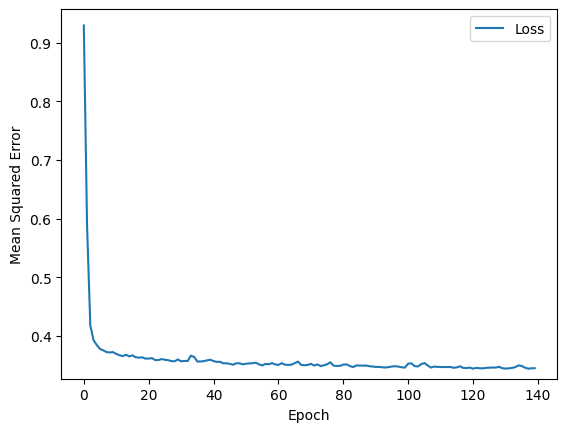


 Evaluate the new model against the test set:
3/3 [==============================] - 0s 2ms/step - loss: 0.4033 - mean_squared_error: 0.3747


[0.403282105922699, 0.3746623992919922]

In [45]:
# Hyperparameters.
learning_rate = 0.007
epochs = 140
batch_size = 1000

label_name = "median_house_value"

my_model = create_model(learning_rate, my_feature_layer)

epochs, mse = train_model(my_model, train_df_norm, epochs, label_name, batch_size)
plot_the_loss_curve(epochs, mse)

# Test the model
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name))
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

In [47]:
print(f"Before regularization: {0.32680 - 0.3669}")
print(f"After regularization: {0.3735 - 0.4033}")

Before regularization: -0.040100000000000025
After regularization: -0.029799999999999993
